# Lab | Logistic Regression Predictions

In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented. We are asked to create a model to predict it. So we use the information we have from May 2005 to create the model.

### Getting data from sakila database

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine

import getpass  # To get the password without showing the input
password = getpass.getpass()

 ········


In [3]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = """
    SELECT title
        , l.name as language
        , rental_duration
        , rental_rate
        , rating
        , length as film_length_minutes
    FROM film
    JOIN language l on film.language_id = l.language_id;
"""
film = pd.read_sql_query(query, engine)
film.head()

,title,language,rental_duration,rental_rate,rating,film_length_minutes
0,ACADEMY DINOSAUR,English,6,0.99,PG,86
1,ACE GOLDFINGER,English,3,4.99,G,48
2,ADAPTATION HOLES,English,7,2.99,NC-17,50
3,AFFAIR PREJUDICE,English,5,2.99,G,117
4,AFRICAN EGG,English,6,2.99,G,130


In [4]:
#get unique film titles and whether it was rented in may

query2 = """
with all_results as(
    SELECT f.title
        , CASE
            WHEN i.inventory_id in (SELECT i.inventory_id
                                    FROM inventory i
                                    JOIN rental r ON i.inventory_id = r.inventory_id
                                    WHERE MONTH(r.rental_date) = 05)
            THEN True
            ELSE False
            END as rented_in_may
    FROM film f
    LEFT JOIN inventory i on f.film_id = i.film_id
)
, rental_totals AS (
    SELECT
        title 
        , sum(rented_in_may) as totals
    FROM all_results
    GROUP BY 1
 )
SELECT
	title
    , CASE WHEN totals>0 THEN 1
		ELSE 0
		END as rented_in_may
FROM rental_totals

"""
rentals = pd.read_sql_query(query2, engine)
rentals.head()

,title,rented_in_may
0,ACADEMY DINOSAUR,1
1,ACE GOLDFINGER,0
2,ADAPTATION HOLES,1
3,AFFAIR PREJUDICE,1
4,AFRICAN EGG,1


In [5]:
film.shape

(1000, 6)

In [6]:
rentals.shape

(1000, 2)

In [7]:
#merging dataframes
data = film.merge(rentals, on= 'title', how='inner')
data.shape

(1000, 7)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                1000 non-null   object 
 1   language             1000 non-null   object 
 2   rental_duration      1000 non-null   int64  
 3   rental_rate          1000 non-null   float64
 4   rating               1000 non-null   object 
 5   film_length_minutes  1000 non-null   int64  
 6   rented_in_may        1000 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 54.8+ KB


### A closer look at the features

- `title`: the title of the film. This column will be dropped.
- `language`: the language of the film. Possible values are English, Italian, Japanese, Mandarin, French, German. This colulmn is categorical nominal.
- `rental_duration`: for how long the film can be rented. Options are 3, 4, 5, 6, 7. This is likely in days. It will be considered categorical nominal.
- `rental_rate`: how much the film is rented for. Options are 0.99, 2.99, 4.99. It will be considered categorical nominal.
- `rating`: the film rating. Options are G, PG, PG-13, R, NC-17. This column will be considered categorical nominal.
- `film_length_minutes`: the film's length in minutes. This is an integer.
- `rented_in_may`: this column indicates a 1 if the movie was rented in may and a 0 if it was not. This is a categorical column.

In [9]:
#dropping title
data2 = data.loc[:, data.columns != "title"]
print(data2.columns)

Index(['language', 'rental_duration', 'rental_rate', 'rating',
       'film_length_minutes', 'rented_in_may'],
      dtype='object')


In [10]:
to_string = ['rental_duration', 'rental_rate']

for col in to_string:
    data2.loc[:,col]=data2.loc[:,col].apply(str)

In [11]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   language             1000 non-null   object
 1   rental_duration      1000 non-null   object
 2   rental_rate          1000 non-null   object
 3   rating               1000 non-null   object
 4   film_length_minutes  1000 non-null   int64 
 5   rented_in_may        1000 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 47.0+ KB


### Looking at distributions of features

In [12]:
def plot_distributions(df):
    numerical_columns = df.select_dtypes(np.number)
    for col in numerical_columns:
        sns.displot(df[col])
        plt.show()

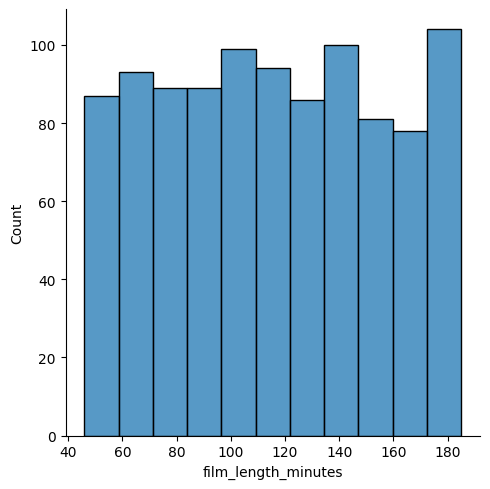

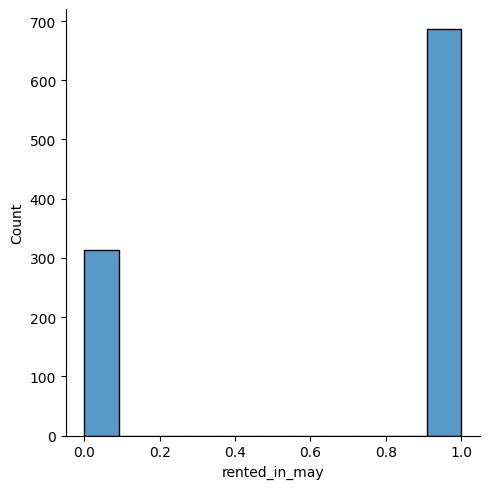

In [13]:
plot_distributions(data2)

In [14]:
def plot_countplot(df):
    categorical_columns = df.select_dtypes('object')
    for col in categorical_columns:
        sns.countplot(x=df[col])
        plt.show()

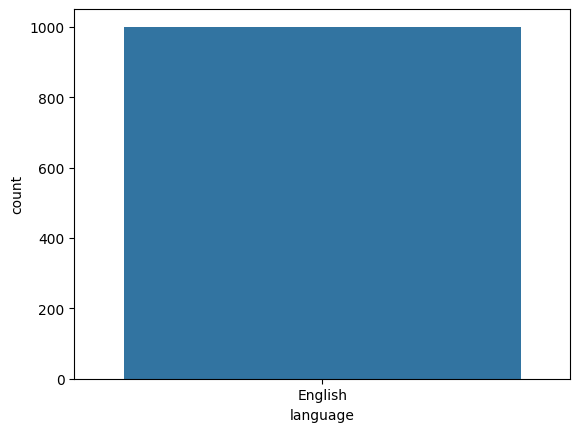

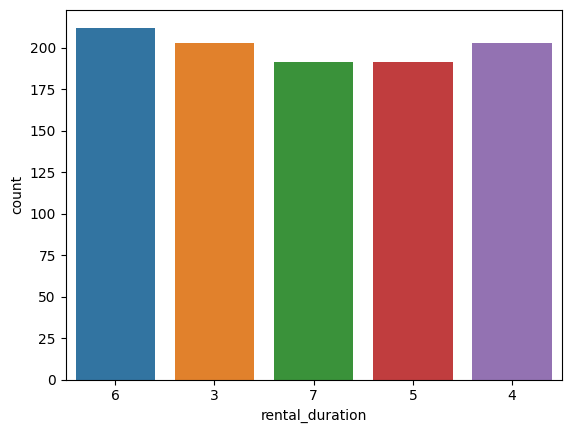

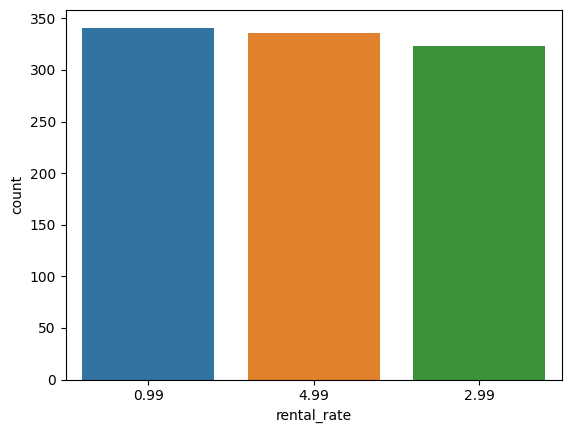

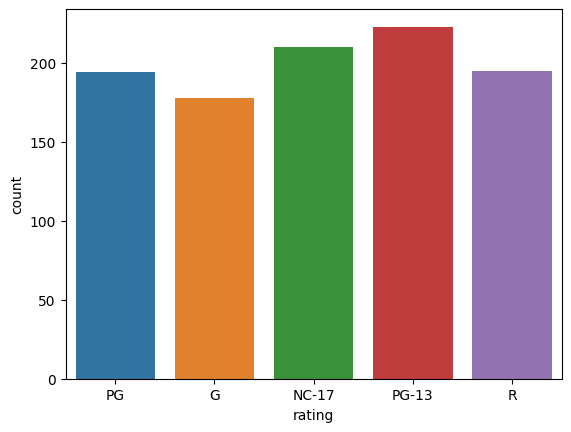

In [15]:
plot_countplot(data2)

We will drop the language column since the language in all movies in the dataset is English. The other features are fairly evenly distributed.

In [16]:
data2 = data2.loc[:, data2.columns != "language"]
print(data2.columns)

Index(['rental_duration', 'rental_rate', 'rating', 'film_length_minutes',
       'rented_in_may'],
      dtype='object')


In [17]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   rental_duration      1000 non-null   object
 1   rental_rate          1000 non-null   object
 2   rating               1000 non-null   object
 3   film_length_minutes  1000 non-null   int64 
 4   rented_in_may        1000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


### X,y split

In [18]:
y = data2['rented_in_may']
X = data2.drop('rented_in_may', axis=1)

### Train, test split

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

### Scaling numerical column

`film_length_min` is the only numerical column. It will be scaled using MinMaxScaler.

In [20]:
from sklearn.preprocessing import MinMaxScaler

#get num values from X_train and X_test

X_train_num = X_train.select_dtypes(include = np.number)
X_test_num = X_test.select_dtypes(include = np.number)

#Scaling data
transformer = MinMaxScaler().fit(X_train_num)

X_train_num_normal = transformer.transform(X_train_num)
X_test_num_normal = transformer.transform(X_test_num)

X_train_num_norm_df = pd.DataFrame(X_train_num_normal, columns=X_train_num.columns, index=X_train_num.index)
X_test_num_norm_df = pd.DataFrame(X_test_num_normal, columns = X_test_num.columns, index=X_test_num.index)


In [21]:
X_train_num_norm_df.describe()

,film_length_minutes
count,700.000000
mean,0.495098
std,0.284148
min,0.000000
25%,0.244604
50%,0.489209
75%,0.728417
max,1.000000


In [22]:
X_test_num_norm_df.describe()

,film_length_minutes
count,300.000000
mean,0.505971
std,0.306232
min,0.000000
25%,0.230216
50%,0.492806
75%,0.764388
max,1.000000


### Transforming categorical columns using OneHotEncoder

In [23]:
#get categorical columns from X_train and X_test

X_train_cat = X_train.select_dtypes('object')
X_test_cat = X_test.select_dtypes('object')

from sklearn.preprocessing import OneHotEncoder

#fit
encoder = OneHotEncoder(drop='first')
encoder.fit(X_train_cat)

#transform
X_train_cat_np = encoder.transform(X_train_cat).toarray()
X_test_cat_np  = encoder.transform(X_test_cat).toarray()

X_train_cat_df = pd.DataFrame(X_train_cat_np, columns=encoder.get_feature_names_out(), index=X_train_cat.index)
X_test_cat_df = pd.DataFrame(X_test_cat_np,  columns=encoder.get_feature_names_out(), index=X_test_cat.index) 

In [24]:
X_train_cat_df.head()

,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7,rental_rate_2.99,rental_rate_4.99,rating_NC-17,rating_PG,rating_PG-13,rating_R
796,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
736,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
414,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
525,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
21,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Merge X_train CAT and NUM sets, X_test CAT and NUM sets

In [25]:
X_train_transformed = pd.concat([X_train_num_norm_df, X_train_cat_df], axis=1)
X_train_transformed.head()

,film_length_minutes,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7,rental_rate_2.99,rental_rate_4.99,rating_NC-17,rating_PG,rating_PG-13,rating_R
796,0.151079,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
736,0.402878,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
414,0.273381,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
525,0.532374,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
21,0.280576,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [26]:
X_train_transformed.shape

(700, 11)

In [27]:
X_test_transformed = pd.concat([X_test_num_norm_df, X_test_cat_df], axis=1)
X_test_transformed.head()

,film_length_minutes,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7,rental_rate_2.99,rental_rate_4.99,rating_NC-17,rating_PG,rating_PG-13,rating_R
866,0.086331,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
191,0.028777,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
732,0.741007,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
657,0.539568,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
155,0.848921,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [28]:
X_test_transformed.shape

(300, 11)

### Creating a logistic regression model

In [29]:
from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial')

#fit
classification.fit(X_train_transformed, y_train)

#predict
y_train_pred = classification.predict(X_train_transformed)
y_test_pred = classification.predict(X_test_transformed)

### Evaluating the model

In [30]:
results = {"Set": ["Train"]*X_train_transformed.shape[0] + ["Test"]*X_test_transformed.shape[0], 
           "Real": y_train.tolist() + y_test.tolist(),
           "Predicted": y_train_pred.tolist() + y_test_pred.tolist()}

results_df = pd.DataFrame(results)
results_df.head()

,Set,Real,Predicted
0,Train,1,1
1,Train,0,1
2,Train,1,1
3,Train,1,1
4,Train,0,1


In [31]:
print(y_test.value_counts())

rented_in_may
1    200
0    100
Name: count, dtype: int64


In [32]:
pd.Series(y_test_pred).value_counts()

1    300
Name: count, dtype: int64

### Accuracy

In [33]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test,y_test_pred))
classification.score(X_test_transformed, y_test)

0.6666666666666666


0.6666666666666666

### Confusion matrix

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(y_test, y_test_pred)

array([[  0, 100],
       [  0, 200]])

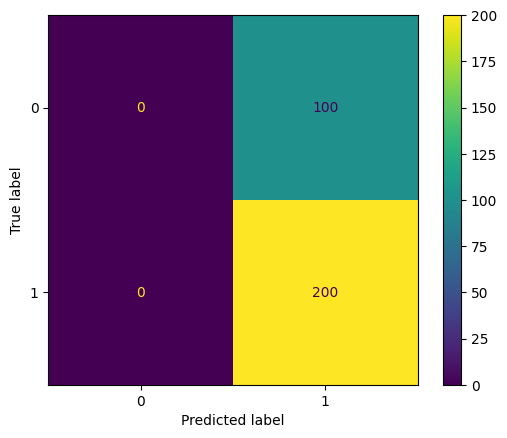

In [35]:
cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm_test,display_labels=classification.classes_)
disp.plot()
plt.show()

### Cohen-Kappa Score

In [36]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y_test, y_test_pred)

0.0

### Classification report

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, zero_division = 1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       100
           1       0.67      1.00      0.80       200

    accuracy                           0.67       300
   macro avg       0.83      0.50      0.40       300
weighted avg       0.78      0.67      0.53       300



In [38]:
# Precission = TP/(TP+FP), Recall = TP/(TP+FN)